In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Direction recontruction (DL2)

**Recommended datasample(s):**
Datasets of fully-analyzed showers used to obtain Instrument Response Functions, which in the default pipeline workflow are called ``gamma3``, ``proton2`` and ``electron``.

**Data level(s):** DL2 (shower geometry + estimated energy + estimated particle classification)

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding the shower geometry of events which have been completely analyzed.

**Requirements and steps to reproduce:**

- get a TRAINING file generated using ``protopipe-DL2`` or the equivalent command from the DIRAC Grid interface

- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n DL2/benchmarks_DL2_direction-reconstruction``

To obtain the list of all available parameters add ``--help-notebook``.

**Development and testing:**  
  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

**TODO:**

* ...

## Table of contents
   - [Energy-dependent offset distribution](#Energy-dependent-offset-distribution)
   - [Angular resolution](#Angular-resolution)
   - [PSF asymmetry](#PSF-asymmetry)
   - [True energy distributions](#True-energy-distributions)

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
cmap = dict()
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
from pathlib import Path
import numpy as np
import pandas as pd

import astropy.coordinates as c
import astropy.wcs as wcs
import astropy.units as u
import matplotlib.pyplot as plt

## Functions

In [3]:
def compute_psf(data, ebins, radius):
    nbin = len(ebins) - 1
    psf = np.zeros(nbin)
    psf_err = np.zeros(nbin)
    for idx in range(nbin):
        emin = ebins[idx]
        emax = ebins[idx+1]
        sel = data.loc[(data['true_energy'] >= emin) & (data['true_energy'] < emax), ['xi']]
        if len(sel) != 0:
            psf[idx] = np.percentile(sel['xi'], radius)
            psf_err[idx] = psf[idx] / np.sqrt(len(sel))
        else:
            psf[idx] = 0.
            psf_err[idx] = 0.
    return psf, psf_err

def plot_psf(ax, x, y, err, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    xlabel = kwargs.get('xlabel', '')
    xlim = kwargs.get('xlim', None)
    
    ax.errorbar(x, y, yerr=err, fmt='o', label=label, color=color) #, yerr=err, fmt='o') #, color=color, label=label)
    ax.set_ylabel('PSF (68% containment)')
    ax.set_xlabel('True energy [TeV]')
    if xlim is not None:
        ax.set_xlim(xlim)
    return ax

## Load data

In [4]:
# Parametrized cell
# Modify these variables according to your local setup outside of the Vagrant Box
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/" # path to 'shared_folder'
output_directory = Path.cwd() # default output directory for plots
analysis_name = "v0.5.0a1"
gammas_infile_name = "DL2_tail_gamma_merged.h5"
protons_infile_name = "DL2_tail_proton_merged.h5"
electrons_infile_name = "DL2_tail_electron_merged.h5"

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
seaborn_settings = {
    "style": "whitegrid",
    "context": "talk",
    "rc": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/DL2"


In [6]:
input_directory = Path(analyses_directory) / analysis_name / Path("data/DL2")
gammas = pd.read_hdf(os.path.join(input_directory, gammas_infile_name), "/reco_events")
protons = pd.read_hdf(os.path.join(input_directory, protons_infile_name), "/reco_events")
electrons = pd.read_hdf(os.path.join(input_directory, electrons_infile_name), "/reco_events")

In [7]:
good_events = gammas[(gammas["is_valid"]==True) & (gammas["NTels_reco"] >= 2) & (gammas["gammaness"] >= 0.75)]

In [8]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

## Benchmarks

Here we use events with the following cuts:
- valid reconstructed events
- at least 2 reconstructed images, regardless of the camera (on top of any other hardware trigger)
- gammaness > 0.75 (mostly a conservative choice)

### Energy-dependent offset distribution
[back to top](#Table-of-contents)

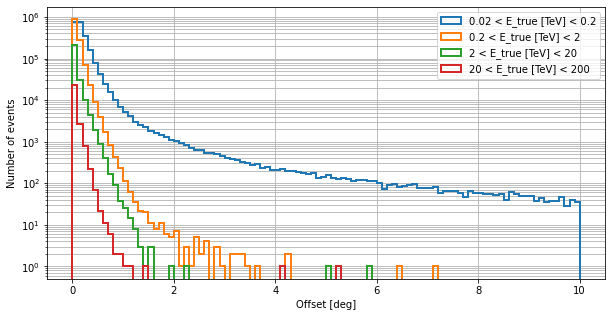

In [9]:
min_true_energy = [0.02, 0.2, 2, 20]
max_true_energy = [0.2, 2, 20, 200]

plt.figure(figsize=(10,5))
plt.xlabel("Offset [deg]")
plt.ylabel("Number of events")

for low_E, high_E in zip(min_true_energy, max_true_energy):
    
    selected_events = good_events[(good_events["true_energy"]>low_E) & (good_events["true_energy"]<high_E)]
    
    plt.hist(selected_events["offset"], 
             bins=100,
             range = [0,10],
             label=f"{low_E} < E_true [TeV] < {high_E}",
             histtype="step",
             linewidth=2)

plt.yscale("log")
plt.legend(loc="best")
plt.grid(which="both")

plt.savefig(plots_folder / f"DL2_offsets_{analysis_name}.png")

plt.show()

### Angular resolution
[back to top](#Table-of-contents)

Here we compare how the multiplicity influences the performance of reconstructed events.

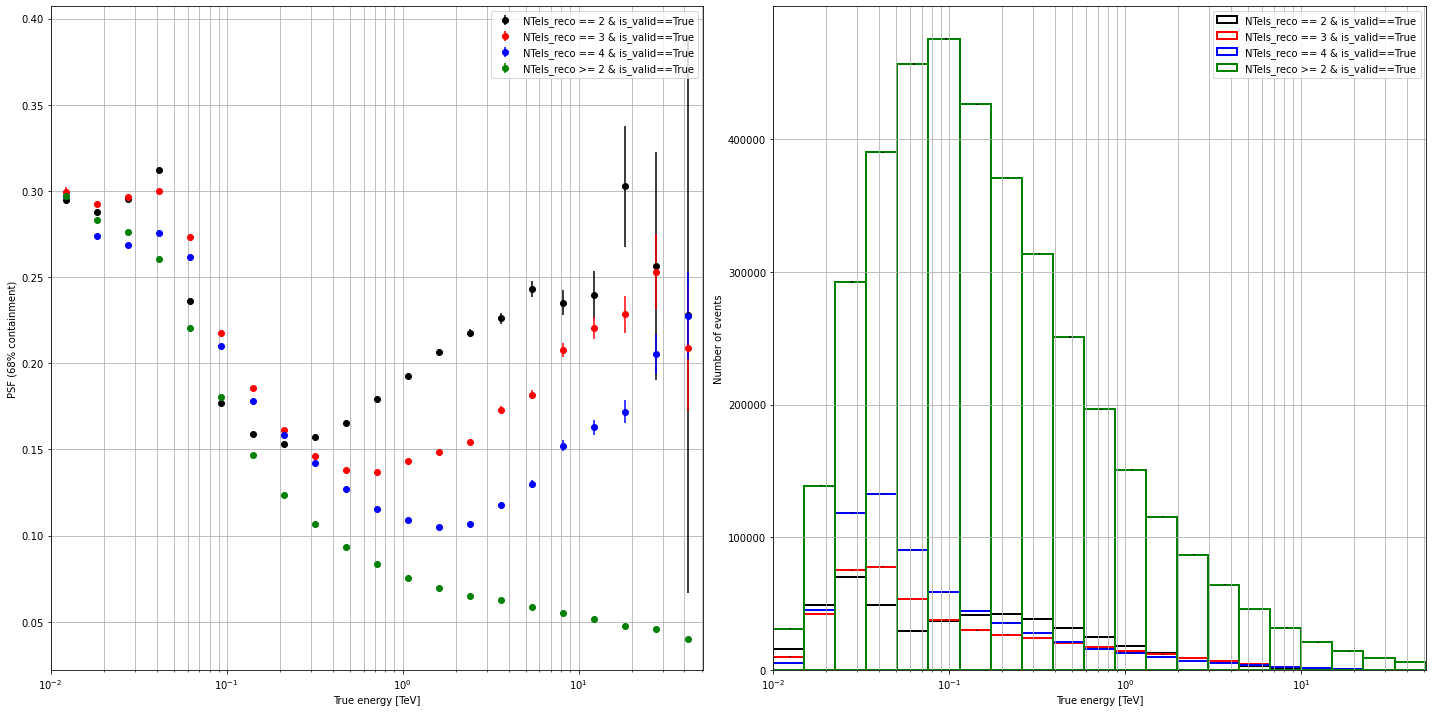

In [10]:
r_containment = 68

energy_bins = 21
max_energy_TeV = 0.0125
min_energy_TeV = 200.0
energy_edges = np.logspace(np.log10(0.01), np.log10(51), energy_bins + 1, True)
energy = np.sqrt(energy_edges[1:] * energy_edges[:-1])
multiplicity_cuts = ['NTels_reco == 2 & is_valid==True',
                     'NTels_reco == 3 & is_valid==True',
                     'NTels_reco == 4 & is_valid==True',
                     'NTels_reco >= 2 & is_valid==True']

events_selected_multiplicity = [good_events[(good_events["NTels_reco"]==2)],
                                good_events[(good_events["NTels_reco"]==3)],
                                good_events[(good_events["NTels_reco"]==4)],
                                good_events[(good_events["NTels_reco"]>=2)]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes = axes.flatten()

cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}

limit = [0.01, 51]
for cut_idx, cut in enumerate(multiplicity_cuts):
    #data_mult = data_evt.query(cut)
    data_mult = events_selected_multiplicity[cut_idx]
    psf, err_psf = compute_psf(data_mult, energy_edges, 68)
    opt={'color': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx]}
    plot_psf(axes[0], energy, psf, err_psf, **opt)
    
    y, tmp = np.histogram(data_mult['true_energy'], bins=energy_edges)
    weights = np.ones_like(y)
    #weights = weights / float(np.sum(y))
    yerr = np.sqrt(y) * weights
    centers = 0.5 * (energy_edges[1:] + energy_edges[:-1])
    width = energy_edges[1:] - energy_edges[:-1]
    axes[1].bar(centers, y * weights, width=width, yerr=yerr, **{'edgecolor': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx], 'lw': 2, 'fill': False})
    axes[1].set_ylabel('Number of events')
    
for ax in axes:
    ax.set_xlim(limit)
    ax.set_xscale('log')
    ax.legend(loc='best')
    ax.grid(which='both')
    ax.set_xlabel('True energy [TeV]')

plt.tight_layout()

fig.savefig(plots_folder / f"DL2_PSF_{analysis_name}.png")

Apply fixed signal efficiency cut (requires well defined ML separator and ML train-ing)

Calculate angular resolution for 68%, 80%, and 95% containment radius.

In [11]:
from pyirf.binning import (
    add_overflow_bins,
    create_bins_per_decade
)

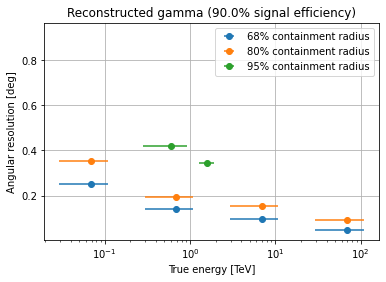

In [12]:
true_energy_bins = create_bins_per_decade(10**-1.9 * u.TeV, 10**2.31 * u.TeV, 1).value

gamma_efficiency = 0.9
reconstructed_gammas = gammas.query("is_valid == True")
gammaness = reconstructed_gammas["gammaness"]
gammaness_cut = np.quantile(gammaness, gamma_efficiency)
selected_events = reconstructed_gammas.query(f"gammaness < {gammaness_cut}")

ang_res_68 = []
ang_res_80 = []
ang_res_95 = []
for i in range(len(true_energy_bins)-1):
    true_energy_mask = f"true_energy > {true_energy_bins[i]} & true_energy < {true_energy_bins[i+1]}"
    selected_offsets = selected_events.query(true_energy_mask)["offset"]
    ang_res_68.append(np.quantile(selected_offsets, 0.68))
    ang_res_80.append(np.quantile(selected_offsets, 0.80))
    ang_res_95.append(np.quantile(selected_offsets, 0.95))

plt.errorbar(
    0.5 * (true_energy_bins[:-1] + true_energy_bins[1:]),
    ang_res_68,
    xerr=10 ** ((np.log10(true_energy_bins[:-1]) + np.log10(true_energy_bins[1:])) / 2.),
    label='68% containment radius',
    fmt='o',
)
plt.errorbar(
    0.5 * (true_energy_bins[:-1] + true_energy_bins[1:]),
    ang_res_80,
    xerr=10 ** ((np.log10(true_energy_bins[:-1]) + np.log10(true_energy_bins[1:])) / 2.),
    label='80% containment radius',
    fmt = "o"
)
plt.errorbar(
    0.5 * (np.log10(true_energy_bins[:-1]) + np.log10(true_energy_bins[1:])),
    ang_res_95,
    xerr=10 ** ((np.log10(true_energy_bins[:-1]) - np.log10(true_energy_bins[1:])) / 2.),
    label='95% containment radius',
    fmt = "o"
)
plt.xlabel("True energy [TeV]")
plt.xscale("log")
plt.ylabel("Angular resolution [deg]")
plt.legend()
plt.title(f"Reconstructed gamma ({gamma_efficiency*100}% signal efficiency)")
plt.grid()

### H_max as a function of energy for gammas and protons

Fixed gamma efficiency at 90%

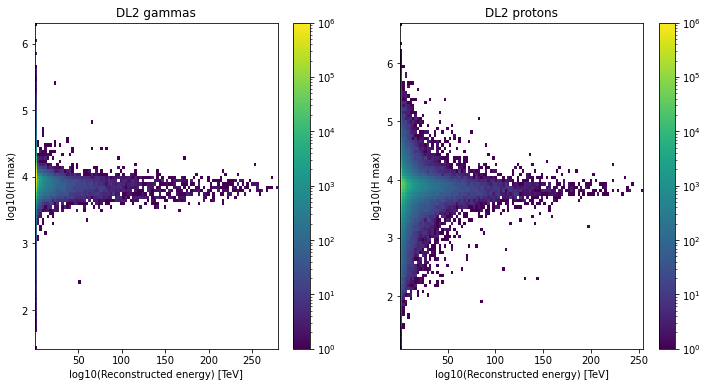

In [13]:
reconstructed_gammas = gammas.query("is_valid == True")
reconstructed_protons = protons.query("is_valid == True")

plt.figure(figsize=(12,6))

mask_gammaness = f"gammaness < 0.9"

plt.subplot(1, 2, 1)

plt.hist2d(reconstructed_gammas.query(mask_gammaness)["reco_energy"],
           np.log10(reconstructed_gammas.query(mask_gammaness)["h_max"]),
           bins=[100,100],
           norm=LogNorm(vmin=1,vmax=1.e6)
          )
plt.xlabel("log10(Reconstructed energy) [TeV]")
plt.ylabel("log10(H max)")
plt.colorbar()
plt.title("DL2 gammas")

plt.subplot(1, 2, 2)

plt.hist2d(reconstructed_protons.query(mask_gammaness)["reco_energy"],
           #np.log10(reconstructed_gammas["true_energy"]),
           np.log10(reconstructed_protons.query(mask_gammaness)["h_max"]),
           bins=[100,100],
           norm=LogNorm(vmin=1,vmax=1.e6)
          )
plt.xlabel("log10(Reconstructed energy) [TeV]")
plt.ylabel("log10(H max)")
plt.colorbar()
plt.title("DL2 protons")
None

### PSF asymmetry
[back to top](#Table-of-contents)

Mean and STDs of sky-projected mis-reconstruction axes
daz = -0.0017 +/- 1.1820 deg
dalt = -0.0104 +/- 0.6975 deg


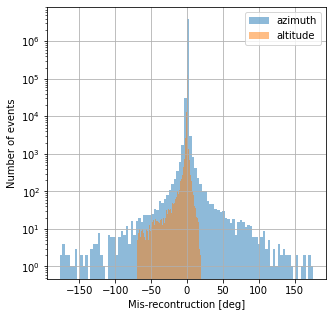

In [14]:
reco_alt = good_events.reco_alt
reco_az = good_events.reco_az

# right now all reco_az for a 180° deg simualtion turn out to be all around -180°
#if ~np.count_nonzero(np.sign(reco_az) + 1):
reco_az = np.abs(reco_az)

# this is needed for projecting the angle onto the sky
reco_az_corr = reco_az * np.cos(np.deg2rad(good_events.reco_alt))

true_alt = good_events.iloc[0].true_alt
true_az = good_events.iloc[0].true_az

daz = reco_az - true_az
daz_corr = daz * np.cos(np.deg2rad(reco_alt))
dalt = reco_alt - true_alt

plt.figure(figsize=(5, 5))

plt.xlabel("Mis-recontruction [deg]")
plt.ylabel("Number of events")

plt.hist(daz_corr, bins=100, alpha=0.5, label = "azimuth")
plt.hist(dalt, bins=100, alpha=0.5, label = "altitude")

plt.legend()
plt.yscale("log")
plt.grid()

print("Mean and STDs of sky-projected mis-reconstruction axes")
print('daz = {:.4f} +/- {:.4f} deg'.format(daz_corr.mean(), daz_corr.std()))
print('dalt = {:.4f} +/- {:.4f} deg'.format(dalt.mean(), dalt.std()))

plt.show()

2D representation with **orange** events being those with **offset < 1 deg** and **E_true > 20 TeV**

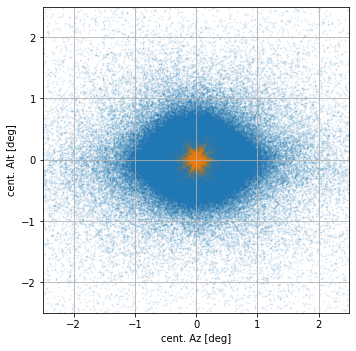

In [15]:
angcut = (good_events['offset'] < 1) & (good_events['true_energy'] > 20)

plt.figure(figsize=(5,5))
ax = plt.gca()
FOV_size = 2.5 # deg

ax.scatter(daz_corr, dalt, alpha=0.1, s=1, label='no angular cut')
ax.scatter(daz_corr[angcut], dalt[angcut], alpha=0.05, s=1, label='offset < 1 deg & E_true > 20 TeV')

ax.set_aspect('equal')
ax.set_xlabel('cent. Az [deg]')
ax.set_ylabel('cent. Alt [deg]')
ax.set_xlim(-FOV_size,FOV_size)
ax.set_ylim(-FOV_size,FOV_size)
plt.tight_layout()
plt.grid(which="both")

fig.savefig(plots_folder / f"PSFasymmetry_2D_altaz_{analysis_name}.png")

### True energy distributions
[back to top](#Table-of-contents)

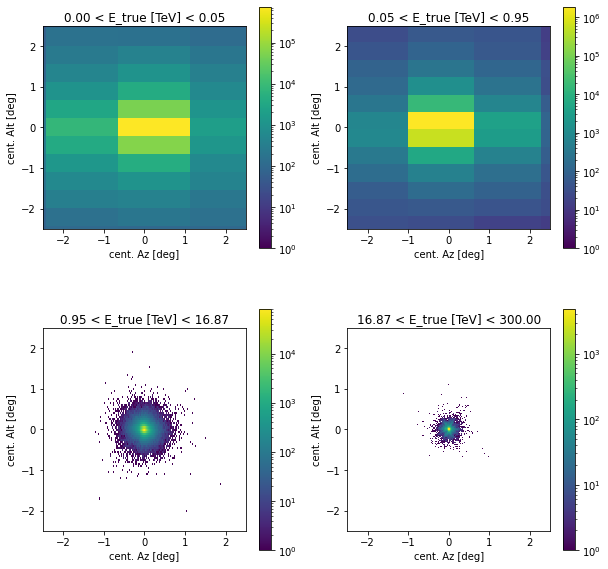

In [16]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.25)
true_energy_bin_edges = np.logspace(np.log10(0.003), np.log10(300), 5)
nbins = 200

for i in range(len(true_energy_bin_edges)-1):
    
    plt.subplot(2, 2, i+1)
    
    mask = (good_events["true_energy"]>true_energy_bin_edges[i]) & (good_events["true_energy"]<true_energy_bin_edges[i+1])
    
    plt.hist2d(daz_corr[mask], dalt[mask], bins=[nbins,nbins], norm=LogNorm())
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.xlim(-FOV_size, FOV_size)
    plt.ylim(-FOV_size, FOV_size)
    plt.title(f"{true_energy_bin_edges[i]:.2f} < E_true [TeV] < {true_energy_bin_edges[i+1]:.2f}")
    plt.xlabel('cent. Az [deg]')
    plt.ylabel('cent. Alt [deg]')